In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters.
batch_size = 128
num_epochs = 25
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
noise_dim = 100
generator_filters = 64
discriminator_filters = 64
channels = 3

In [3]:
transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

In [4]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 170498071/170498071 [00:04<00:00, 35011364.59it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [5]:
# generator class
class Generator(nn.Module):
    def __init__(self, noise_dim, generator_filters, channels):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.generator_filters = generator_filters
        self.channels = channels
        self.main = nn.Sequential(
            nn.ConvTranspose2d(self.noise_dim, self.generator_filters * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.generator_filters * 8),
            nn.ReLU(True),
            # (gen_filters*8) x 4 x 4.
            nn.ConvTranspose2d(self.generator_filters * 8, self.generator_filters * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.generator_filters * 4),
            nn.ReLU(True),
            # (gen_filters*4) x 8 x 8.
            nn.ConvTranspose2d(self.generator_filters * 4, self.generator_filters * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.generator_filters * 2),
            nn.ReLU(True),
            # (gen_filters*2) x 16 x 16.
            nn.ConvTranspose2d(self.generator_filters * 2, self.generator_filters, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.generator_filters),
            nn.ReLU(True),
            # gen_filters x 32 x 32.
            nn.ConvTranspose2d(self.generator_filters, self.channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # channels x 64 x 64.
        )

    def forward(self, input):
        return self.main(input)

In [6]:
# discriminator class
class Discriminator(nn.Module):
    def __init__(self, channels, discriminator_filters):
        super(Discriminator, self).__init__()
        self.channels = channels
        self.discriminator_filters = discriminator_filters
        self.main = nn.Sequential(
            # channels x 64 x 64.
            nn.Conv2d(self.channels, self.discriminator_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # disc_filters x 32 x 32.
            nn.Conv2d(self.discriminator_filters, self.discriminator_filters * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.discriminator_filters * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # (disc_filters*2) x 16 x 16.
            nn.Conv2d(self.discriminator_filters * 2, self.discriminator_filters * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.discriminator_filters * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # (disc_filters*4) x 8 x 8.
            nn.Conv2d(self.discriminator_filters * 4, self.discriminator_filters * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.discriminator_filters * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # (disc_filters*8) x 4 x 4.
            nn.Conv2d(self.discriminator_filters * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [8]:
# Initializing the generator and the discriminator.
generator = Generator(noise_dim, generator_filters, channels).to(device)
discriminator = Discriminator(channels, discriminator_filters).to(device)

# Initializing the weights.
generator.apply(weights_init)
discriminator.apply(weights_init)

# loss function.
criterion = nn.BCELoss()

# optimizer.
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

# Training.
img_list = []
G_losses = []
D_losses = []
iters = 0

fixed_noise = torch.randn(64, noise_dim, 1, 1, device=device)

In [9]:
print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        # Training discriminator with real data
        discriminator.zero_grad()
        real = data[0].to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), 1, dtype=torch.float, device=device)
        output = discriminator(real).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        # Training discriminator with fake data
        noise = torch.randn(b_size, noise_dim, 1, 1, device=device)
        fake = generator(noise)
        label.fill_(0)
        output = discriminator(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        
        # Training generator
        generator.zero_grad()
        label.fill_(1)
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats.
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # saving generators output
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(fake)

        iters += 1

Starting Training Loop...
[0/25][0/391]	Loss_D: 1.7290	Loss_G: 5.8882	D(x): 0.4755	D(G(z)): 0.5069 / 0.0042
[0/25][50/391]	Loss_D: 0.1261	Loss_G: 5.3106	D(x): 0.9521	D(G(z)): 0.0642 / 0.0093
[0/25][100/391]	Loss_D: 0.0963	Loss_G: 10.2426	D(x): 0.9199	D(G(z)): 0.0027 / 0.0001
[0/25][150/391]	Loss_D: 1.9920	Loss_G: 14.8096	D(x): 0.9657	D(G(z)): 0.8148 / 0.0000
[0/25][200/391]	Loss_D: 0.8294	Loss_G: 5.7980	D(x): 0.9588	D(G(z)): 0.4394 / 0.0074
[0/25][250/391]	Loss_D: 0.2856	Loss_G: 8.2156	D(x): 0.9692	D(G(z)): 0.2168 / 0.0004
[0/25][300/391]	Loss_D: 0.7707	Loss_G: 4.8384	D(x): 0.9695	D(G(z)): 0.4230 / 0.0344
[0/25][350/391]	Loss_D: 0.2650	Loss_G: 4.0470	D(x): 0.8597	D(G(z)): 0.0747 / 0.0280
[1/25][0/391]	Loss_D: 0.3423	Loss_G: 5.3158	D(x): 0.9137	D(G(z)): 0.1958 / 0.0076
[1/25][50/391]	Loss_D: 0.3431	Loss_G: 4.4449	D(x): 0.9381	D(G(z)): 0.2095 / 0.0193
[1/25][100/391]	Loss_D: 0.8231	Loss_G: 4.2617	D(x): 0.8895	D(G(z)): 0.4479 / 0.0215
[1/25][150/391]	Loss_D: 0.4297	Loss_G: 2.5771	D(x): 0.

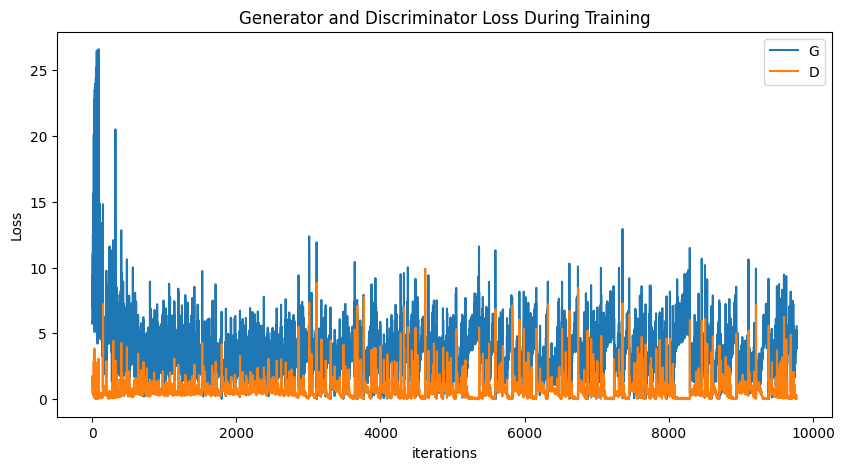

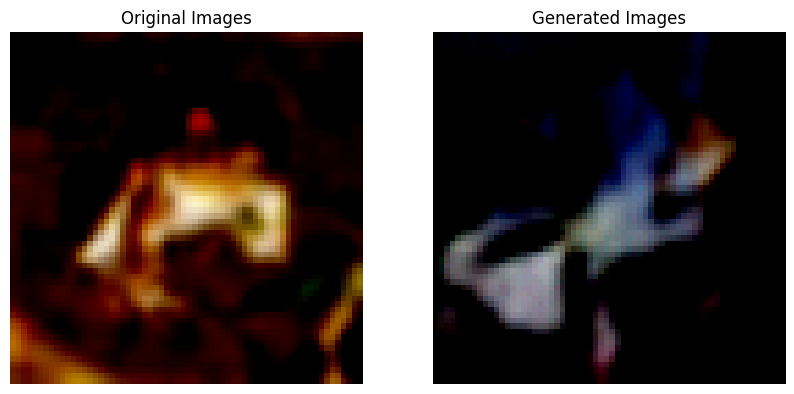

In [10]:
# Save the model checkpoints.
torch.save(generator.state_dict(), 'gen.pth')
torch.save(discriminator.state_dict(), 'disc.pth')

# Plot the training losses.
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot the original images and the generated images.
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Original Images")
plt.imshow(np.transpose(train_dataset[0][0],(1,2,0)))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(img_list[-1][0],(1,2,0)))
plt.show()

In [11]:
# generate 10 images using the trained generator and save them in a folder.
import os
os.makedirs('images', exist_ok=True)
imgs = []
with torch.no_grad():
    for i in range(10):
        noise = torch.randn(1, noise_dim, 1, 1, device=device)
        fake = generator(noise).detach().cpu()
        plt.figure(figsize=(1,1))
        plt.axis("off")
        plt.imshow(np.transpose(fake[0],(1,2,0)))
        plt.savefig('images/fake_image_%d.png' % i)
        plt.close()

In [12]:
# report inception score on the generated images.
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data

from torchvision.models.inception import inception_v3

import numpy as np
from scipy.stats import entropy

def inception_score(imgs, cuda=True, batch_size=1, resize=False, splits=1):
    """Computes the inception score of the generated images imgs

    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)    

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [13]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

class CustomImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_files = os.listdir(root)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.image_files[idx])
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img

transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

dataset = CustomImageFolder(root='images', transform=transform)

print("Calculating Inception Score...")
print(inception_score(dataset, cuda=True, batch_size=1, resize=True, splits=10))

Calculating Inception Score...


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 68.7MB/s]


(1.0, 0.0)


/tmp/ipykernel_27/85553272.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()
